**Оглавление:**<a id='toc0_'></a>    
- [Расчёт юнит экономики привлечения клиентов из разных каналов](#toc1_)    
  - [Цель](#toc1_1_)    
  - [Задачи](#toc1_2_)    
  - [Описание](#toc1_3_)    
  - [План](#toc1_4_)    
- [Обзор данных](#toc2_)    
    - [Импортируем библиотеки и считаем данные из файлов в dataframe](#toc2_1_1_)    
    - [Обзор таблиц](#toc2_1_2_)    
    - [Диагностика данных](#toc2_1_3_)    
- [Предобработка данных](#toc3_)    
- [Расчёты](#toc4_)    
    - [Построение графика распределения LTV пользователей по каналам привлечения](#toc4_1_1_)    
    - [Создание сводной таблицы по каналам привлечения клиентов](#toc4_1_2_)    
    - [Объединение таблицы затрат и сводной таблицы](#toc4_1_3_)    
    - [Расчёт метрики CAC](#toc4_1_4_)    
    - [Расчёт прибыли на один юнит для каналов привлечения](#toc4_1_5_)    
    - [Построение графика прибыли на одного юнита по каналам привлечения](#toc4_1_6_)    
- [Результаты](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Расчёт юнит экономики привлечения клиентов из разных каналов](#toc0_)

## <a id='toc1_1_'></a>[Цель](#toc0_)
Произвести рассчёты эффективности вложения средств в разные каналы привлечения клиентов.

## <a id='toc1_2_'></a>[Задачи](#toc0_)
1. Определить какие каналы окупаются;
2. Определить какой из каналов самый прибыльный с точки зрения прибыли на один юнит;
3. Сформулировать бизнес выводы на основании данных расчётов.

## <a id='toc1_3_'></a>[Описание](#toc0_)
Данные о LTV пользователей и стоимости привлечения находятся в файлах `customers.csv` и `cost_attraction.csv`. Перед выполнением расчётов необходимо произвести обзор данных. В предобработке данных будет произведена проверка на наличие ошибок в данных и при их наличии оценка их влияния на рассчёты. После этого будут осуществлены расчёты и формирование бизнес выводов.

В файле `customers.csv` содержится статистика по клиентам, привлеченным из каналов.
Поля:
- id клиента - номер клиента;
- Канал привлечения - канал из которого пришел клиент;
- LTV клиента, руб. - сколько прибыли принёс клиент за всё время взаимодействия с компанией.

В файле `cost_attraction.csv` содержится информация о общей стоимости привлечения для каждого канала.
Поля:
- Канал привлечения - канал, на который выполнены расходы на привлечение;
- Стоимость привлечения, руб. - сколько всего было потрачено на привлечение в данном канале.

## <a id='toc1_4_'></a>[План](#toc0_)
1. Обзор данных
2. Предобработка данных
3. Расчёты
4. Результаты расчётов

# <a id='toc2_'></a>[Обзор данных](#toc0_)
Проведём обзор данных с целью понять их структуру и проверить наличие ошибок

### <a id='toc2_1_1_'></a>[Импортируем библиотеки и считаем данные из файлов в dataframe](#toc0_)

Определим также функцию для диагностики данных в dataframe

In [27]:
import pandas as pd
import numpy as np

# сохраняем в df данные по LTV пользователей
df_customers = pd.read_csv('data/customers.csv', sep = ';')

# сохраняем в df данные по затратам на привлечение в каждом канале
df_cost_attr = pd.read_csv('data/cost_attraction.csv', sep = ';')

# функция для диагностики df
def df_diagnostics(df):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({'dtypes': df.dtypes, 'count': df.count(), 'unique': df.nunique(),
                         'NaN count': df.isnull().sum(), 'NaN percentage': df.isnull().sum() / df.shape[0]})
    
    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {'mean': lambda s: s.mean(), 'median': lambda s: s.median(), 'std': lambda s: s.std(),
               'min':  lambda s: s.min(),  'max':    lambda s: s.max()}
    
    # Используем цикл по словарю, чтобы вычислить метрики для каждого столбца
    for metric, func in metrics.items():
        diag[metric] = [func(df[col]) if pd.api.types.is_numeric_dtype(df[col]) else np.nan 
                        for col in df.columns]
    
    # Вычисляем количество дублирующих строк в DataFrame
    duplicates_count = df.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)
    return diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)

### <a id='toc2_1_2_'></a>[Обзор таблиц](#toc0_)

Обзор данных по пользователям из таблицы `customers.csv`

In [28]:
df_customers.head()

,id клиента,Канал привлечения,"LTV, руб."
0,1,Реклама у блогеров,350
1,2,Реклама у блогеров,205
2,3,Реклама у блогеров,252
3,4,Таргетная реклама,531
4,5,Реклама у блогеров,325


Обзор данных по стоимости привлечения в каналах из таблицы `cost_attraction.csv`

In [29]:
df_cost_attr

,Канал привлечения,"Стоимость привлечения, руб."
0,Таргетная реклама,100000
1,e-mail рассылки,25000
2,Реклама у блогеров,120000
3,Контекстная реклама,90000
4,Нативная реклама,70000
5,Реклама в новостных СМИ,60000


### <a id='toc2_1_3_'></a>[Диагностика данных](#toc0_)

In [30]:
# диагностика df с пользователями
df_diagnostics(df_customers)

Количество дублирующих строк: 0


,dtypes,count,unique,NaN count,NaN percentage,mean,median,std,min,max
id клиента,int64,1801,1801,0,0.000000,901.000000,901.000000,520.048235,1.000000,1801.000000
Канал привлечения,object,1801,6,0,0.000000,nan,nan,nan,nan,nan
"LTV, руб.",int64,1801,594,0,0.000000,274.234870,313.000000,2370.053981,-100000.000000,802.000000


Диагностика таблицы `customers.csv` показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- строк 1801
- клиенты по полю id `клиента` все уникальные
- 6 уникальных каналов привлечения клиентов
- пропусков нет
- в поле `LTV, руб.` минимальное значение -100000, ошибка данных, удалим его

In [31]:
# диагностика df со стоимостью привлечения
df_diagnostics(df_cost_attr)

Количество дублирующих строк: 0


,dtypes,count,unique,NaN count,NaN percentage,mean,median,std,min,max
Канал привлечения,object,6,6,0,0.000000,nan,nan,nan,nan,nan
"Стоимость привлечения, руб.",int64,6,6,0,0.000000,77500.000000,80000.000000,33429.029301,25000.000000,120000.000000


Диагностика таблицы `cost_attraction.csv` показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответсвуют
- строк 6
- пропусков нет
- числовые значения в поле `Стоимость привлечения, руб.` корректны

# <a id='toc3_'></a>[Предобработка данных](#toc0_)

В столбце `LTV, руб.` минимальное значение равно `-100000` - это ошибка в данных, удалим данную строку. После этого повторно выведем идагностику df.

In [32]:
# пересохраним в df с данными по клиентам все строки, кроме строки с ошибочным значением
df_customers = df_customers[df_customers['LTV, руб.'] != -100000]

# повторная диагностика df
df_diagnostics(df_customers)

Количество дублирующих строк: 0


,dtypes,count,unique,NaN count,NaN percentage,mean,median,std,min,max
id клиента,int64,1800,1800,0,0.000000,900.500000,900.500000,519.759560,1.000000,1800.000000
Канал привлечения,object,1800,6,0,0.000000,nan,nan,nan,nan,nan
"LTV, руб.",int64,1800,593,0,0.000000,329.942778,313.000000,167.332549,70.000000,802.000000


Выведем уникальные названия каналов

In [33]:
# уникальные значения в поле
df_customers['Канал привлечения'].unique()

array(['Реклама у блогеров', 'Таргетная реклама', 'e-mail рассылки',
       'Контекстная реклама', 'Реклама в новостных СМИ',
       'Нативная реклама'], dtype=object)

Все названия каналов уникальные.

Мы выполнили предобработку данных, а именно:
- удалили из таблицы `customers.csv` одну строку с ошибочным значением LTV равным - 100000.

# <a id='toc4_'></a>[Расчёты](#toc0_)

### <a id='toc4_1_1_'></a>[Построение графика распределения LTV пользователей по каналам привлечения](#toc0_)
Построим график распределения LTV пользователей по каналам привлечения с целью увидеть из каких каналов пользователи в среднем приносят больше или меньше LTV.

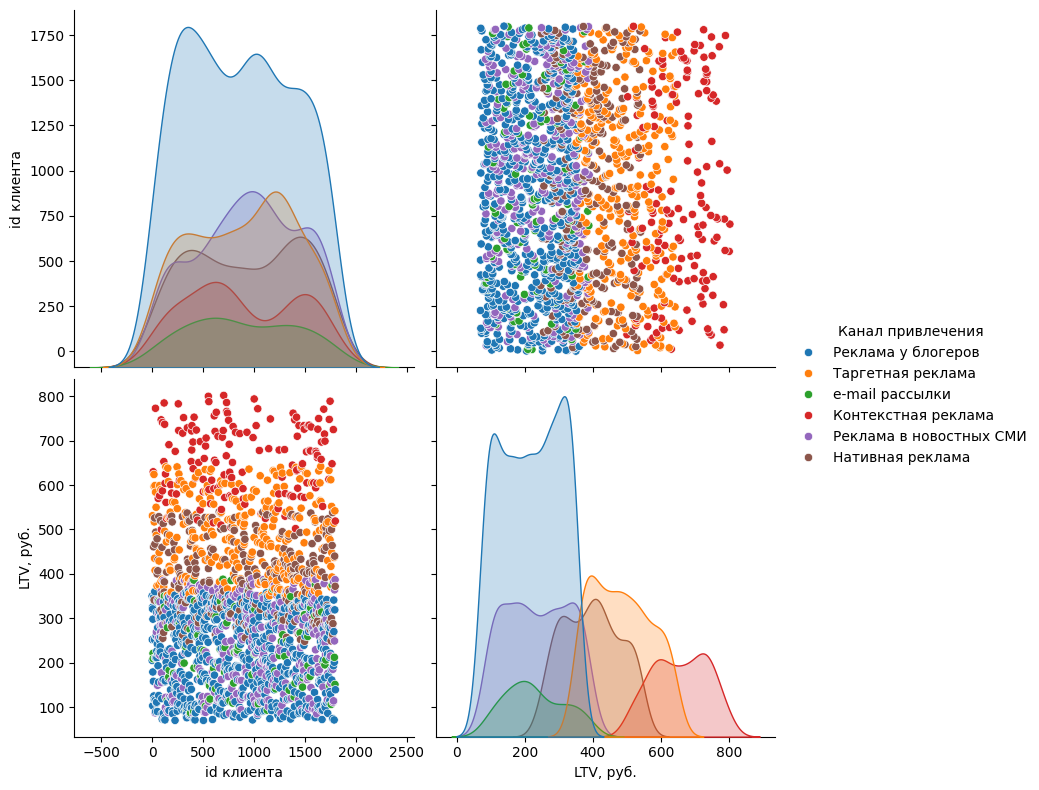

In [34]:
# импорт пакетов для графиков
from matplotlib import pyplot as plt
import seaborn as sns

# строим график распределения
sns.pairplot(df_customers, hue = 'Канал привлечения', height=4)
plt.show()

Из представленного графика мы видим, что например чётко прослеживается то, что каналы `Контекстная реклама` и `Таргетная реклама` приводят клиентов, у которых LTV в среднем выше, а например канал `Реклама у блогеров` приводит клиентов с меньшим LTV.

### <a id='toc4_1_2_'></a>[Создание сводной таблицы по каналам привлечения клиентов](#toc0_)
В сводную таблицу добавим два новых столбца:
1. Средний LTV на канал в руб.;
2. Кол-во клипентов, пришедших из канала.

In [35]:
# создаём сводную таблицу
df_agg = df_customers.groupby(['Канал привлечения',]).agg(
	mean = ('LTV, руб.', lambda x: round(x.mean(), 0)),  # Средний LTV на канал в руб. Подсчёт с округлением
	count = ('LTV, руб.', 'count'),                      # Кол-во клипентов, пришедших из канала. Подсчёт без округления
	).reset_index()

# переименовываем названия столбцов
df_agg.rename(columns={'mean': 'Средний LTV, руб.', 'count': 'Кол-во клиентов'}, inplace=True)
df_agg

,Канал привлечения,"Средний LTV, руб.",Кол-во клиентов
0,e-mail рассылки,229.0,96
1,Контекстная реклама,656.0,154
2,Нативная реклама,395.0,255
3,Реклама в новостных СМИ,236.0,312
4,Реклама у блогеров,217.0,671
5,Таргетная реклама,483.0,312


### <a id='toc4_1_3_'></a>[Объединение таблицы затрат и сводной таблицы](#toc0_)
Объединим таблицу затрат и сводную таблицу с целью увидеть общую картину.

In [36]:
# соединяем таблицы по полю `Канал привлечения`
df_group = pd.merge(df_cost_attr, df_agg, on='Канал привлечения', how='inner')
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов
0,Таргетная реклама,100000,483.0,312
1,e-mail рассылки,25000,229.0,96
2,Реклама у блогеров,120000,217.0,671
3,Контекстная реклама,90000,656.0,154
4,Нативная реклама,70000,395.0,255
5,Реклама в новостных СМИ,60000,236.0,312


### <a id='toc4_1_4_'></a>[Расчёт метрики CAC](#toc0_)
Расчитаем метрику CAC для каждого канала привлечения с целью узнать сколько приходится затрат в среднем на одного пользователя.

In [37]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов` с округлением
df_group = df_group.assign(cac = round(df_group['Стоимость привлечения, руб.'] / df_group['Кол-во клиентов'], 1))
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,cac
0,Таргетная реклама,100000,483.0,312,320.5
1,e-mail рассылки,25000,229.0,96,260.4
2,Реклама у блогеров,120000,217.0,671,178.8
3,Контекстная реклама,90000,656.0,154,584.4
4,Нативная реклама,70000,395.0,255,274.5
5,Реклама в новостных СМИ,60000,236.0,312,192.3


### <a id='toc4_1_5_'></a>[Расчёт прибыли на один юнит для каналов привлечения](#toc0_)
Расчитаем для каждого канала среднюю прибыль на 1 пользователя через вычитание из среднего LTV и средних затрат на одного пользователя.

In [38]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов`
df_group = df_group.assign(ltv_cac = round(df_group['Средний LTV, руб.'] - df_group['cac'], 1))

# переименовываем названия столбцов
df_group.rename(columns={'cac': 'CAC, руб.', 'ltv_cac': 'Прибыль на 1 юнит, руб.'}, inplace=True)
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,"CAC, руб.","Прибыль на 1 юнит, руб."
0,Таргетная реклама,100000,483.0,312,320.5,162.5
1,e-mail рассылки,25000,229.0,96,260.4,-31.4
2,Реклама у блогеров,120000,217.0,671,178.8,38.2
3,Контекстная реклама,90000,656.0,154,584.4,71.6
4,Нативная реклама,70000,395.0,255,274.5,120.5
5,Реклама в новостных СМИ,60000,236.0,312,192.3,43.7


### <a id='toc4_1_6_'></a>[Построение графика прибыли на одного юнита по каналам привлечения](#toc0_)
Для наглядности построим график и покажем на нём для каждого канала привлечения среднюю прибыль на одного пользователя.

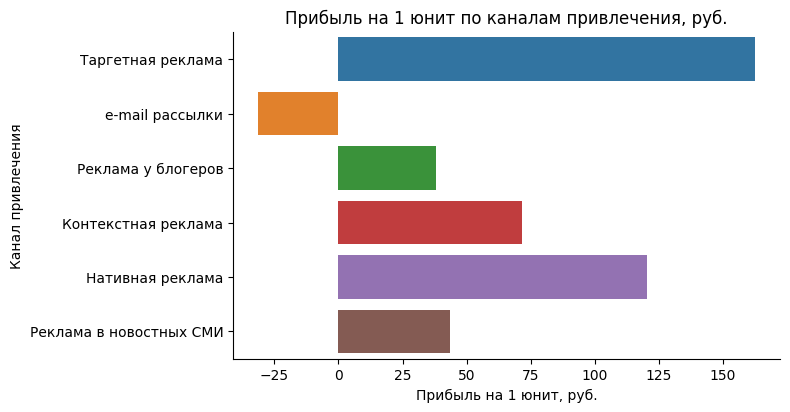

In [39]:
# построим график
sns.catplot(data=df_group, x="Прибыль на 1 юнит, руб.", y="Канал привлечения", kind="bar", orient="h",
            hue="Канал привлечения", height=4, aspect=2).set(title='Прибыль на 1 юнит по каналам привлечения, руб.')

Мы выполнили расчёты, а именно:
- в сводной таблице для каждого канала привлечения расчитали следующие показатели `Средний LTV, руб.` и `Кол-во клиентов`;
- объединили таблицу с общими затратами по каналам и сводную таблицу;
- расчитали метрику CAC;
- для каждого канала привлечения рассчитали прибыль на 1 юнит.

# <a id='toc5_'></a>[Результаты](#toc0_)
Вопрос 1: Определить какие каналы окупаются.
Ответ: Окупаются все каналы, кроме `e-mail рассылки`.

Вопрос 2: Определить какой из каналов самый прибыльный с точки зрения прибыли на один юнит.
Ответ: Самым прибыльным каналом является `Таргетная реклама`. 

Вопрос 3: Сформулировать бизнес выводы на основании данных расчётов.
Ответ: Канал `e-mail рассылки` приносит убытки и по этому, если у него нет прогнозов, что вскоре через этот канал будет приходить более платежеспособный клиент, то от него стоит отказаться. Канал `Таргетная реклама` самый выгодный с точки зрения прибыли на 1 клиента, поэтому инвестиции в него стоит увеличивать.